**Samuel Munoz**

Spring 2021

CS 252: Mathematical Data Analysis and Visualization

Project 7: Radial Basis Function Neural Networks

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## Task 1: RBF Network development dataset

The eventual goal is to train a neural network so that it learns to recognize which human handwritten digit is shown in an image  (i.e. the numbers 0, 1, ..., 9). Before doing this, you will use simpler data to develop and debug your network.

### 1a. Load and preprocess data

- Load in the `rbf_dev_train.csv` and `rbf_dev_test.csv` train and test sets.
- For the train and test sets, separate the data variables (`X` and `Y`) from the class values (*class*). The test code below assumes the following names:
    - `y_train` and `y_test` for the class values in the train and test sets, respectively.
    - `rbf_dev_train` and `rbf_dev_test` for the train and test set data, respectively.
- Normalize each data feature "separately" between 0 and 1 (based on each feature's dynamic range).
    - Use the `min` and `max` values derived from the training set to normalize the test set. *This will ensure that identical feature values in the training and test sets get normalized to the same numeric value.*

**Tip:** It might be a good idea to write a few functions below so that you don't have a lot of duplicate code when processing train and test sets.

In [2]:
# create function to split data into X and Y
def split(data):
    # find M features
    m = data.shape[1]
    
    # return data points and sample's class
    return data[:, :(m-1)], data[:, m-1].astype(int)

In [3]:
# load dev train and test datasets
all_train = pd.read_csv("data/rbf_dev_train.csv", delimiter=",")
all_test = pd.read_csv("data/rbf_dev_test.csv", delimiter=",")

# convert dataframe into ndarray
all_train = all_train.to_numpy()
all_test = all_test.to_numpy()

# split data into data samples and their classes
rbf_dev_train, y_train = split(all_train)
rbf_dev_test, y_test = split(all_test)

#### Preprocessing test code

The following test code is a good sanity check, but you are encouoraged to do additional testing to make sure that your preprocessing pipeline is working properly.

##### Check dtypes

In [4]:
print(f'Your training set is an ndarray? {isinstance(rbf_dev_train, np.ndarray)}')
print(f'Your training classes is an ndarray? {isinstance(y_train, np.ndarray)}')
print(f'Your test set is an ndarray? {isinstance(rbf_dev_test, np.ndarray)}')
print(f'Your test classes is an ndarray? {isinstance(y_test, np.ndarray)}')

Your training set is an ndarray? True
Your training classes is an ndarray? True
Your test set is an ndarray? True
Your test classes is an ndarray? True


##### Check shapes

In [5]:
print(f'Your training set shape is {rbf_dev_train.shape} and should be (1600, 2).')
print(f'Your training classes shape is {y_train.shape} and should be (1600,).')
print(f'Your test set shape is {rbf_dev_test.shape} and should be (400, 2).')
print(f'Your test classes shape is {y_test.shape} and should be (400,).')

Your training set shape is (1600, 2) and should be (1600, 2).
Your training classes shape is (1600,) and should be (1600,).
Your test set shape is (400, 2) and should be (400, 2).
Your test classes shape is (400,) and should be (400,).


##### Check dtypes (detailed)

Remove from assigned project

In [6]:
print(f'Your training set is an float? {isinstance(rbf_dev_train[0,0], float)}')
print(f'Your training classes is an int? {isinstance(y_train[0], np.int64)}')
print(f'Your test set is an float? {isinstance(rbf_dev_test[0,0], float)}')
print(f'Your test classes is an int? {isinstance(y_test[0], np.int64)}')

Your training set is an float? True
Your training classes is an int? True
Your test set is an float? True
Your test classes is an int? True


##### Check normalization (detailed)

Remove from assigned project

In [7]:
print(f'Your training set mins/maxs: {rbf_dev_train.min(axis=0)}/{rbf_dev_train.max(axis=0)}\nand should be                [0. 0.]/[1. 1.]')
print(f'Your test set mins/maxs: {rbf_dev_test.min(axis=0)}/{rbf_dev_test.max(axis=0)}\nand should be            [0.02038 0.01194]/[0.99805 0.98749]')

print(f'Training values look ok? {len(np.unique(rbf_dev_train)) > 2}')
print(f'Test values look ok? {len(np.unique(rbf_dev_test)) > 2}')

Your training set mins/maxs: [-22.94 -22.88]/[23.18 29.87]
and should be                [0. 0.]/[1. 1.]
Your test set mins/maxs: [-22.   -22.25]/[23.09 29.21]
and should be            [0.02038 0.01194]/[0.99805 0.98749]
Training values look ok? True
Test values look ok? True


### 1b. Plot data

Create a scatter plot of the training data in the cell below.

- Color code each sample by its output class.
- Make the aspect ratio (height and width) of the x and y axes in the figure equal, otherwise the plot may look distorted.

If everything is working properly, you should see a jack-o-lantern whose eyes, noise, mouth, and stem are colored differently than the rest of the face.

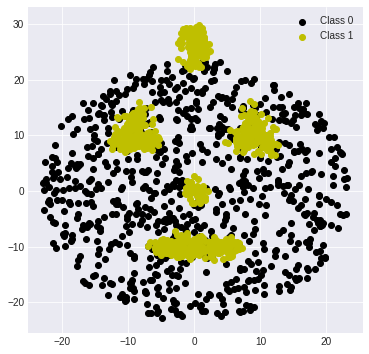

In [8]:
# plot all training data
plt.figure(figsize=(6, 6))
plt.scatter(rbf_dev_train[y_train == 0][:, 0], rbf_dev_train[y_train == 0][:, 1], c="k", label="Class 0")
plt.scatter(rbf_dev_train[y_train == 1][:, 0], rbf_dev_train[y_train == 1][:, 1], c="y", label="Class 1")
plt.legend()
plt.show()

## Task 2: Radial basis function neural network

In [9]:
from rbf_net import RBF_Net

### 2a. Network initalization

You will use K-means to initialize the RBF hidden layer prototypes and sigmas.

1. Copy over your `kmeans.py` from your previous project. If your K-means clustering code isn't working properly, you may use `scipy` functions in this project instead, but at a 1 point reduction. Check out `scipy.cluster.vq.kmeans`.

2. Implement the method templates in `rbf.py` that initialize the hidden layer of the neural network:
    - Finish writing the constructor
    - `get_num_hidden_units`
    - `get_num_output_units`
    - `avg_cluster_dist`: Compute the average distance between each cluster center found by K-means and all the points assigned to the same cluster.
    - `initialize`: Use K-means to set the Gaussian hidden unit centers (**prototypes**) and standard deviations (**sigmas**).


In [10]:
from kmeans import KMeans

#### Test `avg_cluster_dist`

In [11]:
np.random.seed(0)

# N = 10 samples, M = 5 features
test_data = np.random.normal(size=(10, 5))
# 4 hidden units / prototypes, each has 5 features
test_centroids = np.random.normal(size=(4, 5))
# Each sample assigned to one of 4 hidden unit prototypes
test_assignments = np.random.randint(low=0, high=4, size=(10,))
kmeansObj = KMeans()

test_net = RBF_Net(4, 3)
print(f'Number of hidden units in your net is {test_net.get_num_hidden_units()} and should be 4')
print(f'Number of output units in your net is {test_net.get_num_output_units()} and should be 3')
test_clust_mean_dists = test_net.avg_cluster_dist(test_data, test_centroids, test_assignments, kmeansObj)

print(f'Your avg within cluster distances are\n{test_clust_mean_dists} and should be\n[2.23811 3.94891 3.12267 3.4321]')

Number of hidden units in your net is 4 and should be 4
Number of output units in your net is 3 and should be 3
Your avg within cluster distances are
[2.23811 3.94891 3.12267 3.4321 ] and should be
[2.23811 3.94891 3.12267 3.4321]


#### Test `initialize`

In [12]:
test_net.initialize(test_data)

print(f'Your prototypes have shape {test_net.get_prototypes().shape} and the shape should be (4, 5).')
print(f'Your hidden unit sigmas have shape {test_net.sigmas.shape} and the shape should be (4,).')

Your prototypes have shape (4, 5) and the shape should be (4, 5).
Your hidden unit sigmas have shape (4,) and the shape should be (4,).


#### Test initialization methods

In the cell below, write test code for your RBF network initialization:
- Create a new RBF network with 7 hidden units and 2 output classes.
- Call the `initalize` method on it, passing in the training data.
- Create a class color-coded scatterplot of the training data with an equal axis aspect ratio, like above, now with the prototypes clearly marked with a different marker and/or color.

You should see fairly evenly distributed prototypes, with one in most, if not all, "pockets" of samples belonging to a single class.

In [13]:
# Keep me
np.random.seed(0)

# Create your network here
# create RBF network with 7 hidden units and two output classes
rbf_obj = RBF_Net(7, 2)

# initalize rbf object
rbf_obj.initialize(rbf_dev_train)

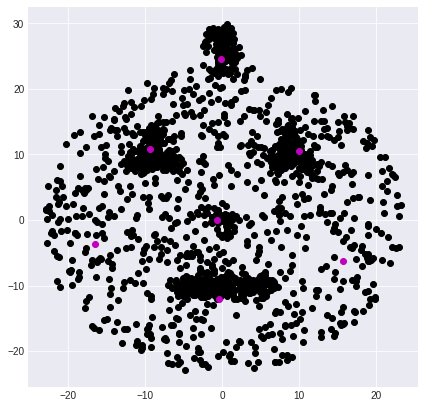

In [14]:
# Your plot here
plt.figure(figsize=(7, 7))
plt.scatter(rbf_dev_train[:, 0], rbf_dev_train[:, 1], c="k")
prototypes = rbf_obj.prototypes
plt.scatter(prototypes[:, 0], prototypes[:, 1], c="m")


plt.show()

**Question 1:** Do you think the prototypes enable the RBF network to learn the data well? Why or why not?

**Answer 1:** Yes, I do because I believe that the spread out prototypes will help capture the features in this data. Thus, when new data is presented to the network, the network will better be able to classify the new data because the network has been trained to capture many features of the data set above.

### 2b. Compute hidden and output layer activations

Implement the following methods so that you can train your RBF network:
- `hidden_act`: Computes hidden layer activation values: Determines the similarity between hidden layer prototypes with the input data.
- `output_act`: Computes output layer activation values: Multiply hidden unit activation by output unit weights.

**Hidden unit activation**:

The activation of hidden unit $j$ to data sample $i$ is computed according to $$H_{ij} = \exp \left (-\frac{\text{dist} \left (\vec{x}_i, \vec{c}_j \right )^2}{2\sigma_j^2 + \epsilon}\right )$$ 
where $\vec{x_i}$ is the data sample, $\vec{c_j}$ is the prototype (center) of the hidden unit, $\sigma_j$ is the hidden unit's standard deviation, $\epsilon$ is a small number (e.g. 1e-8), and $dist(\cdot, \cdot)^2$ is the **squared** Euclidean distance.

#### Test hidden_act

In [15]:
np.random.seed(1)

# N = 3 samples, M = 5 features
test_data = np.random.normal(size=(3, 5))
# 4 hidden units / prototypes, each has 5 features
test_centroids = np.random.normal(size=(4, 5))
# Each sample assigned to one of 4 hidden unit prototypes
test_sigmas = np.random.uniform(size=(4,))
test_wts = 2*np.random.uniform(size=(4+1, 3)) - 1

test_net = RBF_Net(4, 3)
test_net.prototypes = test_centroids
test_net.sigmas = test_sigmas
test_net.wts = test_wts
test_h_act = test_net.hidden_act(test_data)
print(f'Your hidden layer activation is\n{test_h_act}\n\nand should be')
print('[[0.      0.      0.00009 0.00033]\n [0.00013 0.      0.00004 0.00014]\n [0.      0.      0.      0.00001]]')

Your hidden layer activation is
[[0.      0.      0.00009 0.00033]
 [0.00013 0.      0.00004 0.00014]
 [0.      0.      0.      0.00001]]

and should be
[[0.      0.      0.00009 0.00033]
 [0.00013 0.      0.00004 0.00014]
 [0.      0.      0.      0.00001]]


#### Test output_act

In [16]:
test_out_act = test_net.output_act(test_h_act)
print(f'Your output layer activation is\n{test_out_act}\n\nand should be')
print('[[-0.72136  0.61505 -0.20481]\n [-0.72151  0.61487 -0.20466]\n [-0.72144  0.61479 -0.20465]]')

Your output layer activation is
[[-0.72136  0.61505 -0.20481]
 [-0.72151  0.61487 -0.20466]
 [-0.72144  0.61479 -0.20465]]

and should be
[[-0.72136  0.61505 -0.20481]
 [-0.72151  0.61487 -0.20466]
 [-0.72144  0.61479 -0.20465]]


### 2c. Learn network weights using linear regression

To train your RBF network, you will need to find optimal weights between hidden and output layer neurons to allows your network to accurately classify the training data (i.e. learn from the data). An efficient solution is to use linear regression to solve a least square problem: minimizing the squared difference between the *hidden layer activations* and the *true data classes*.

In `rbf.py`, implement `linear_regression(A, y)`. To do this, adapt your code in `linear_regression` to use your QR solver.

#### Test linear regression

Running the following test code should generate a familar regression fit to the Iris data.

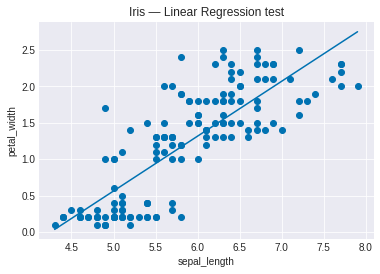

In [17]:
df = pd.read_csv('https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv')
iris = df[['sepal_length', 'petal_width']].to_numpy()

num_hidden_units = 1
num_classes = 4
net = RBF_Net(num_classes=num_classes, num_hidden_units=num_hidden_units)
iris_x = np.reshape(iris[:, 0], [len(iris), 1])
iris_y = np.reshape(iris[:, 1], [len(iris), 1])
iris_c = net.linear_regression(iris_x, iris_y)

line_x = np.linspace(iris_x.min(), iris_x.max())
line_y = line_x * iris_c[0] + iris_c[1]
plt.scatter(iris_x, iris_y)
plt.plot(line_x, line_y)
plt.title('Iris — Linear Regression test')
plt.xlabel('sepal_length')
plt.ylabel('petal_width')
plt.show()

### 2d. Train your RBF Network

Implement the following methods then train your neural network! In the cell below, train a RBF network with 10 hidden units on the RBF dev dataset. **If everything is working, you should get >=88% accuracy on the training set and >=89% on the test set.**

- `train`: Determine the optimal output layer weights that fit hidden layer activation using linear regression.
- `predict`: Use trained network (after learning) to predict the class of data.
- `accuracy`: Compute the accuracy by comparing the network predicted and actual class for each data sample.



In [18]:
# training network
n_hidden_units = 10
n_classes = 2

rbf_obj = RBF_Net(n_hidden_units, n_classes)
rbf_obj.train(rbf_dev_train, y_train)

In [19]:
# Training set accuracy
pred = rbf_obj.predict(rbf_dev_train)
print(f"Training data prediction: {rbf_obj.accuracy(y_train, pred)}")

Training data prediction: 0.894375


In [20]:
# Test set accuracy
pred = rbf_obj.predict(rbf_dev_test)
print(f"Training data prediction: {rbf_obj.accuracy(y_test, pred)}")

Training data prediction: 0.905


## Task 3: Handwritten digit classification: MNIST data

You will train a RBF network on a "real" image dataset of handwritten number digits:
- 60,000 images in training set, 10,000 images in test set.
- Each image is 28x28 pixels.
- The images are grayscale (no RGB colors).
- Each image (data sample) contains ONE of 10 numeric digit $0, 1, 2, \ldots, 8, 9$.

The goal is to train your network so that it can correctly predict the numeric digit in an image.

More information about MNIST: http://yann.lecun.com/exdb/mnist/

### 3a. Load in and look at MNIST dataset

- Use the numpy function `load` to load in the MNIST train/test data and the associated class labels.
- Create a 5x5 grid showing the first 25 images in the dataset. It should "look good" (e.g. turn off tick marks).

In [21]:
# Load data here
x_train = np.load("data/mnist_train_data.npy")
y_train = np.load("data/mnist_train_labels.npy")
x_test = np.load("data/mnist_test_data.npy")
y_test = np.load("data/mnist_test_labels.npy")

In [22]:
print(f'Your training set shape is {x_train.shape} and should be (60000, 28, 28).')
print(f'Your training classes shape is {y_train.shape} and should be (60000,).')
print(f'Your test set shape is {x_test.shape} and should be (10000, 28, 28).')
print(f'Your test classes shape is {y_test.shape} and should be (10000,).')

Your training set shape is (60000, 28, 28) and should be (60000, 28, 28).
Your training classes shape is (60000,) and should be (60000,).
Your test set shape is (10000, 28, 28) and should be (10000, 28, 28).
Your test classes shape is (10000,) and should be (10000,).


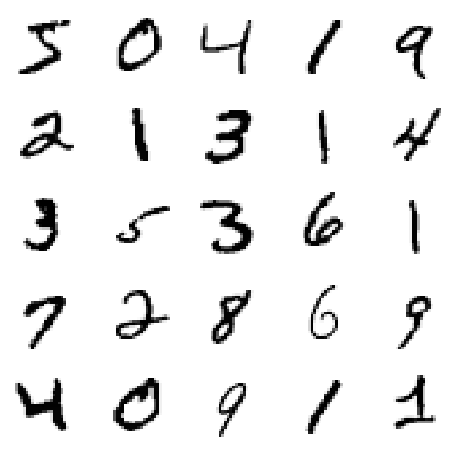

In [23]:
# 5x5 plot here
# get first 25 images in dataset
firsts = x_train[:25]

# loop through all subplots
plt.subplots(nrows=5, ncols=5, figsize=(8, 8))
for row in range(5):
    for col in range(5):
        # compute index
        i = row*5 + col + 1
        plt.subplot(5, 5, i)
        
        # plot
        plt.imshow(firsts[i-1])
        plt.xticks([])
        plt.yticks([])
        
plt.show()        

### 3b. Preprocess data

- Flatten non-leading dimensions of the train and test sets. For example, the training set should go from (60000, 28, 28) to (60000, 784). **Do not hard code this!** Your code should work for any data with three dimensions.
- Normalize so that the maximum possible value in each image is 1 (and the minimum possible is 0) by dividing by 255.

In [24]:
n, m1, m2 = x_train.shape
x_train_flat = np.reshape(x_train, (n, m1*m2)) / 255

n, m1, m2 = x_test.shape
x_test_flat = np.reshape(x_test, (n, m1*m2)) / 255

### 3c. Train and assess performance on MNIST

Train a RBF network on MNIST. **Your goal is to get >=90% accuracy on both train and test sets.**

**Tips:**
- Depending on your laptop or machine you are using, training could take many hours if you use the full 60,000 sample training set. Select a subset to train on (e.g. ~1500) that takes a reasonable amount of time (e.g. minutes). You should be able to hit your accuracy goals without too much data, effort, or time.
- Do not pare down the test set (i.e. it should remain at 10,000 samples).
- Use the code below to visualize your hidden layer prototypes to help with debugging (assumes your network is called `mnist_net`). Your prototypes should look like images of certain digits, perhaps a little blurrier.

In [84]:
import time

# start clock
t0 = time.time()

# initialize data train data set
data_train = x_train_flat[:1500]
label_train = y_train[:1500]
n_hidden = 45
n_classes = 10
mnist_net = RBF_Net(n_hidden, n_classes)
mnist_net.train(data_train, label_train)

# stop clock
t1 = time.time()

In [85]:
# start clock
t2 = time.time()

# train acc
pred = mnist_net.predict(data_train)
print(f"Training dataset: {mnist_net.accuracy(label_train, pred)}")

# stop clock
t3 = time.time()

Training dataset: 0.8826666666666667


In [86]:
# start clock
t4 = time.time()

# test acc
pred = mnist_net.predict(x_test_flat)
print(f"Training dataset: {mnist_net.accuracy(y_test, pred)}")

# end clock
t5 = time.time()

Training dataset: 0.8445


In [87]:
# determine time elapse
t = (t1-t0) + (t3-t2) + (t5-t4)
print(f"Time elapsed: {t:{4}.{6}} seconds")

Time elapsed: 12.9655 seconds


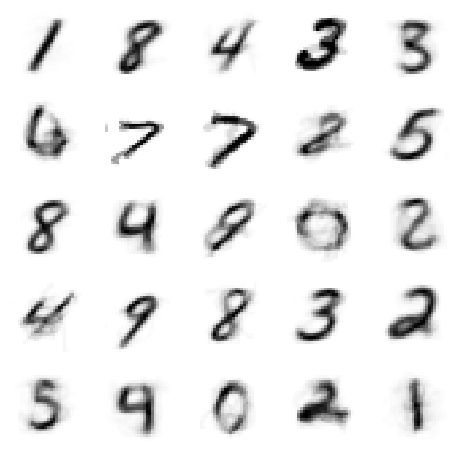

In [28]:
# Visualize network hidden layer prototypes
prototypes = mnist_net.get_prototypes()
prototypes = np.reshape(prototypes, [prototypes.shape[0], 28, 28])

cols = rows = 5
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8, 8))
for i in range(rows):
    for j in range(cols):
        axes[i, j].imshow(prototypes[i*rows + j])
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

**Question 2:** Which part of the training process takes the longest?

**Answer 2:** I found the training the RBF object took the longest amount of time. I think this occurs because of the all the distances the RBF object needs to compute (very computationally intensive task).

**Question 3:** What accuracy did you achieve on the training set? List all parameters that you needed to set (e.g. number of training samples, number hidden units, etc).

**Answer 3:** The accuracy I achieved on the training set is 86.4% accuracy. The RBF object I used used 45 hidden units, took in 1500 samples, and had 10 classes. I changed the amount of hidden units I used. I found that after roughly 45-50 hidden units, the rate at which accuracy increased was very minimal (about another 1-2%). However, when increasing the hidden units to roughly 65+, the time it takes to compute the accuracy was too long. Thus, I lowered the number of hidden unit to achieve a lower accuracy in much quicker time.

**Question 4:** Using the same parameters to get the training accuracy that you reported in Question 3, what test accuracy did you achieve?

**Answer 4:** The accuracy I achieved on the testing set is 83.3% accuracy. The RBF object I used used 45 hidden units, took in 1500 samples, and had 10 classes.

### 3d. Visualize prototypes using network weights

Now that you've trained the network to recognize handwritten digits, let's visualize the dominant factors that the network learns to rely on to make each prediction.

Create a 10 x 5 plot showing images of the 5 "most influential hidden layer prototypes" that contribute to predicting each of the 10 output classes. These are defined as the hidden layer prototypes that have the 5 largest weights going from the hidden layer to the output layer. *Recall that each hidden unit prototype has the same shape as a single data sample so each image in your grid should be 28x28.*

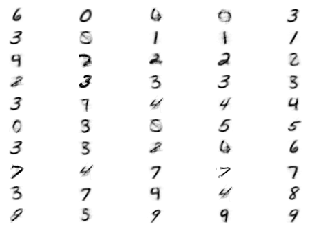

In [29]:
# loop through all weights
indices = np.zeros( (mnist_net.wts.shape[1], 5) )
for c in range(mnist_net.wts.shape[1]):
    # get weights for given class
    weights = mnist_net.wts[:, c]
    
    # determine indices of the 5 largest weights
    # credit to source: https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
    index_max = np.argpartition(weights, -5)[-5:]
    
    # store results
    indices[c] = index_max
    
# change type of indices
indices = indices.astype(int)
    
# plot results
plt.subplots(nrows=mnist_net.wts.shape[1], ncols=5)
for row in range(mnist_net.wts.shape[1]):
    for col in range(5):
        # compute index
        i = 5*row + col
        
        # plot on subplot
        plt.subplot(mnist_net.wts.shape[1], 5, i+1)
        proto = mnist_net.prototypes[indices[row, col]]
        proto_reshape = np.reshape(proto, (28, 28))
        plt.imshow(proto_reshape)
        plt.xticks([])
        plt.yticks([])
    
plt.show()

**Question 5:** Interpret what each row of your 10x5 grid of images means. Did any of the top prototypes surprise you?

**Answer 5:** Each row in the represents the prototypes with the strongest assoication with a given class. In this class, if I label first row 0, then second 1, and so on, then the images in a row represent what RBF thinks is the best matches of row index i. The results make me think that there is something wrong with my RBF object. Given that everything else looks right, I going to assume this assumption is wrong. I would expect that on each row i, I would see images of the number i, like on row 3. However, on somes rows like row 8, I see variety of different number. I guess that for many numbers, the RBF object is a bit confused on what a number i looks like. 

## Task 4: RBF neural networks for regression

In this task you will make modest changes and configure your RBF neural network to enable it to perform regression rather than solve classification problems.

### Task 4a. Plot regression curve data

Download and load in the regression "x values" (`'rbf_regression_x.npy'`) and "y values" (`'rbf_regression_y.npy'`). Create a plot of the curve that you on which will perform regression.

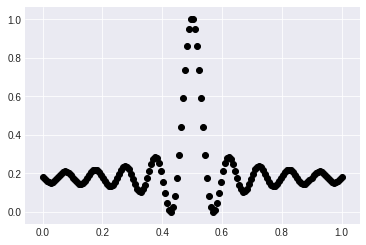

In [30]:
# load data
x_reg = np.load("data/rbf_regression_x.npy")
y_reg = np.load("data/rbf_regression_y.npy")

# plot data
plt.scatter(x_reg, y_reg, c="k")
plt.show()

### 4b. Implement a RBF Neural Network for Regression 

Implement the methods in the `RBF_Reg_Net` class. In every case except the constructor, this involves copy-pasting code from your classification network and making small changes.

Note that the hidden unit variance gain parameter ($g$) modifies the RBF function as follows:

$$H_{ij} = \exp \left (-\frac{\text{dist} \left (\vec{x}_i, \vec{c}_j \right )^2}{2g*\sigma_j^2 + \epsilon}\right )$$

#### Test: RBF regression neural network

- Create an object of the `RBF_Reg_Net` network. Configure it with:
    - 1 output neuron
    - 50 hidden units
    - the default value for the hidden unit variance gain.
- Train the network and have it predict y values at the training x values.
- Plot the original (x, y) values on the curve, and along with the predicted y values at the same x values.

**If everything is working, the regression performed by your network should produce an almost "perfect" reconstruction of the original data curve.**

In [31]:
from rbf_net import RBF_Reg_Net

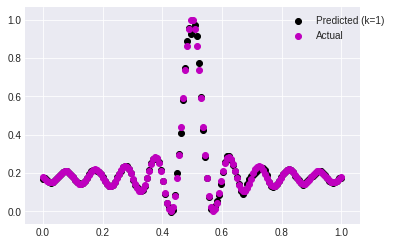

In [32]:
# create and train object
rbf_reg_net = RBF_Reg_Net(50, 1)
rbf_reg_net.train(x_reg, y_reg)

# make predictions
pred_1 = rbf_reg_net.predict(x_reg)

# plot results
plt.scatter(x_reg, pred_1, c="k", label="Predicted (k=1)")
plt.scatter(x_reg, y_reg, c="m", label="Actual")
plt.legend(bbox_to_anchor=(1.1, 1))
plt.show()

### 4c. Analysis of RBF Regression Neural Network

**Question 6:** Below, train the RBF regression network again, but with the hidden unit variance gain set to 1 .Superimpose the predicted regression curve with the original curve in the same plot. What happens and why?

**Answer 6:** What occurs is that positions of the predicted value appear to wildly vary. This is noticebale in center of the curve where points equidistance from the y-axis do not have the y-value like in the plot above. This is the result of the K-Means curve being too wide. As a result of being too wide, a x-value can be assigned a wider range of y-values. Thus, you get what shows in the plot below where prediction values vary widely from actual values.

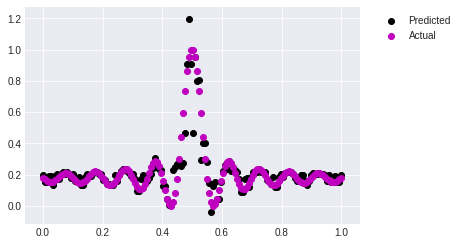

In [33]:
# retrain object
rbf_reg_net = RBF_Reg_Net(50, 1, 1)
rbf_reg_net.train(x_reg, y_reg)

# make more predictions
pred_2 = rbf_reg_net.predict(x_reg)

# plot results
plt.scatter(x_reg, pred_2, c="k", label="Predicted")
plt.scatter(x_reg, y_reg, c="m", label="Actual")
plt.legend(bbox_to_anchor=(1.3, 1))
plt.show()

**Question 7:** Run an experiment where you fix the hidden unit variance gain parameter to 5 and vary the number of hidden units in the network between 5 and 50. Create a plot showing the MSSE of the predictions vs the original data for each networks with a different number of hidden units. Explain what the plot reveals about the number of hidden units in the network.

**Answer 7:** The plot shows that there is point where increasing the number of hidden units yield minimal to no improvements. Thus, I just need to find the smallest number of hidden units such that there is hardly any improvement in the MSSE.

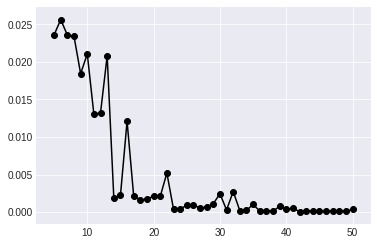

In [34]:
# store results
msse = []

# run loop
for n_units in range(5, 51):
    # create and train object
    rbf_obj = RBF_Reg_Net(n_units, 1)
    rbf_obj.train(x_reg, y_reg)
    
    # get predictions
    pred = rbf_obj.predict(x_reg)
    
    # compute and store MSSE
    answer = pred - y_reg
    answer = answer**2
    answer = np.sum(answer)
    msse.append(answer / y_reg.size)
    
# plot results
n_units = np.arange(5, 51)
plt.plot(n_units, msse, "k-")
plt.scatter(n_units, msse, c="k")
plt.show()

**Question 8:** Run an experiment where you fix the number of hidden units to 10 and vary the hidden unit variance gain parameter between 2 and 50. Create a plot showing the MSSE of the predictions vs the original data for each networks with a different gain parameter value. Explain what the plot reveals about the hidden unit variance in the network.

**Answer 8:** The plot shows that there is point where increasing the hidden unit variance gain parameter value yield minimal to no improvements. Thus, I just need to find the smallest gain parameter value such that there is hardly any improvement in the MSSE. Note that the improvement in the this test are much smaller than the previous result, which may imply that changing the hidden unit variance gain parameter may not impact the performance of the RBF network as much as changing the number of hidden units used.

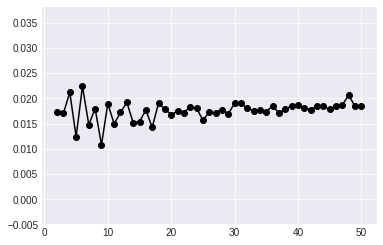

In [35]:
# store results
msse = []

# run loop
for n_gain in range(2, 51):
    # create and train object
    rbf_obj = RBF_Reg_Net(10, 1, n_gain)
    rbf_obj.train(x_reg, y_reg)
    
    # get predictions
    pred = rbf_obj.predict(x_reg)
    
    # compute and store MSSE
    answer = pred - y_reg
    answer = answer**2
    answer = np.sum(answer)
    msse.append(answer / y_reg.size)
    
# plot results
n_units = np.arange(2, 51)
plt.scatter(n_units, msse, c="k")
plt.plot(n_units, msse, "k-")
plt.show()

## Extensions

To receive credit for any extension, you must:
- Not modify / prevent any code from the core project from working (e.g. make a copy before changing). In other words, **the notebook test code should still work!**
- **You must describe what you did and what you found in detail**. This includes a summary of parameter values used in your simulations.
- Include (*labeled!*) plots and/or numbers to present your results.
- Write up your extensions below or in a separate notebook.

**Rule of thumb: one deep, thorough extension is worth more than several quick, shallow extensions!**

### 1) Improve performance on MNIST with PCA

Using all 768 features (pixels) in each image may not be very helpful for classification. For example, pixels around the border are almost always white. Transform the dataset(s) using PCA to compress the number of features before training your RBF network. Experiment with PCA to improve classification accuracy and runtime performance.

**Extension: Improving Performance with PCA**

The idea for the extension was to compress the number of features in my RBF network. However, I have struggled to actually achieve this task. So far, the PCA anaylsis below does not improve accuracy nor the runtime of the network. I don't have time any more to continue with this extension. However, I do know that I have not actually reduced any features with PCA in the code below. I am not sure where to continue from here, but I have left my code here if you want to look at it. If I had the time, I would have question to either Professor Wolfe or Layton about what is going wrong here or whether I understand what to do for this extension. I don't expect any points to given for this.

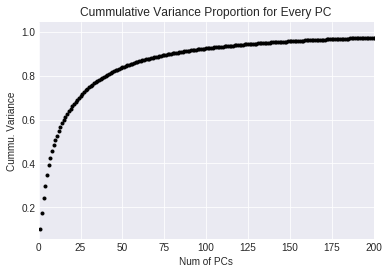

/personal/smunoz23/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: ComplexWarning: Casting complex values to real discards the imaginary part


In [104]:
from pca_cov import PCA_COV

# work with first 1500 samples
n_first = 1500
x_data = x_train_flat[:n_first]
y_data = y_train[:n_first]

# Variable names to remember
# x_test_flat
# y_test

# convert data into pandas dataframe
x_pd_train = pd.DataFrame(x_data)

# create PCA_Cov object and initialize it
pca = PCA_COV(x_pd_train)

# compute PCA on all data points
# not normalizing as a result of divide by zero error
indices = np.arange(784)
pca.pca(indices)

# determine a good number of PCs to keep
pca.elbow_plot()

# set lower and upper bounds for the x-axis
x_lower = 0
x_upper = 200
plt.xlim(x_lower, x_upper)
plt.show()

# graph on requires a 100 PCs to capture 90% of total variance

# project n number of pcs
pca_data = pca.pca_then_project_back(175)

# cast away all complex part of numbers of pca computation
pca_data = pca_data.astype(float)
# pca_data = np.reshape(flat_data, [flat_data.shape[0], 28, 28])

In [105]:
# time results
import time

# start clock
t0 = time.time()

# create and train RBF object
hidden_unit = 45
rbf_obj = RBF_Net(hidden_unit, 10)
rbf_obj.train(pca_data, y_data)

# predict results for training data set
pred = rbf_obj.predict(pca_data)

# compute accuracy for training data set
print(f"Training Data Set Accuracy: {rbf_obj.accuracy(y_data, pred)}")

# predict results for testing data set
pred = rbf_obj.predict(x_test_flat)

# compute accuracy for testing data set
print(f"Testing Data Set Accuracy: {rbf_obj.accuracy(y_test, pred)}")

# end clock
t1 = time.time()

# compute elapsed time
t = t1 - t0
print(f"Time elapsed: {t:{4}.{6}} seconds")

Training Data Set Accuracy: 0.8586666666666667
Testing Data Set Accuracy: 0.838
Time elapsed: 12.6873 seconds


### 2) Visualize network predictions

Make visualizations to show and interpret the MNIST network predictions. Lots of possibilities, here are a few specific ideas:
- Make show a grid of test samples labeled with their predicted digit.
- Analyze if the network performance favors accuracy for certain digits and not others.
- Are errors on certain classes correlated in any way? Does it depend on their digit similarity (e.g. 1 looks like a 7, but not a 0).
- Make and interpret a confusion plot.

### 3) Explore parameter space

When training your RBF network on MNIST, you had to pick some parameter values to use by hand. Pick one or more parameters and systematically vary them to quantify their effect on accuracy and simulation time.

### 4) Initialization schemes

Research, test out, and quantify the performance of different techniques to set the hidden unit prototypes and sigmas. For example, an alternative way to initialize the prototypes is to perform K-means to cluster each class *separately*. 

### 5) Other datasets

Use your RBF network to classify other datasets.

### 6) SVD-based linear regression

Implement a SVD-based linear regression method, which is both fast and numerically accurate. In the equation $Ac = y$ The weights $c$ can be solved via the following matrix equation: $$c = A^+y$$ where $A^+$ is the pseudo inverse of the matrix of RBF hidden layer activations $A$ (*data matrix*) and the correct classes $y$.

Relying on numpy to figure out the pseudoinverse would be a mini extension, computing the pseudoinverse yourself would be a larger extension.

### 7) Analyze the trained network

Run simulations then analyze and interpret the results. Here are some ideas:
- Visualize and analyze how the prototypes influence the classification results.
- Visualize and analyze how the network weights influence the classification results.

### 8) RBF networks for regression

- Analyze the regression neural network's performance in scenarios when the training set is not equal to the training set.
- Explore and analyze how the RBF network could perform regression on a function with several inputs (e.g. $z = f(x, y)$). Test with real or simulated data.
- Explore and analyze how the RBF network could perform regression on a vector valued function with several outputs (e.g. $(y, z) = f(x)$). Test with real or simulated data.